In [1]:
%%bash
pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.2 MB/s eta 0:00:00


In [1]:
from google.colab import auth

auth.authenticate_user()

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt
from wordsegment import load, segment
import re
load()

In [3]:
model_id = "roberta-base"
data_path = "gs://cil_2023/"
filename_train_pos = "train_pos_full.txt"
filename_train_neg = "train_neg_full.txt"

!gsutil cp "gs://cil_2023/train_pos_full.txt" .
!gsutil cp "gs://cil_2023/train_neg_full.txt" .

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Copying gs://cil_2023/train_pos_full.txt...
- [1 files][ 82.1 MiB/ 82.1 MiB]                                                
Operation completed over 1 objects/82.1 MiB.                                     
Copying gs://cil_2023/train_neg_full.txt...
|
Operation completed over 1 objects/101.4 MiB.                                    


In [4]:
# read dataset
dataset_pos_pd = pd.read_fwf(filename_train_pos, sep='\n', header=None, names=['text'])
dataset_neg_pd = pd.read_fwf(filename_train_neg, sep='\n', header=None, names=['text'])
dataset_pos_pd['label'] = 0
dataset_neg_pd['label'] = 1
dataset_pd = pd.concat([dataset_pos_pd, dataset_neg_pd])

In [ ]:
# preprocessing
def unhashtag(tweet):
  offset = 0
  for h in re.finditer(r'#\S+', tweet):
    start, end = h.span()
    new_string = ' '.join(segment(h.group(0))) + ' '
    tweet = tweet[:(start+offset)] + new_string + tweet[(end+offset+1):]
    offset += len(new_string) - (end - start + 1)
  return tweet

# should take about 10 min
for i, tweet in enumerate(dataset_pd['text'].tolist()):
  if '#' in tweet:
    dataset_pd['text'].iloc[i] = unhashtag(tweet)

In [5]:
# shuffle
dataset_pd = dataset_pd.sample(frac=1, random_state=0).reset_index(drop=True)

In [ ]:
# tokenize
tokenizer = AutoTokenizer.from_pretrained(model_id)
texts = tokenizer.batch_encode_plus(dataset_pd['text'].tolist(),
                                    padding=True, truncation=True,
                                    return_tensors='tf')

dataset = tf.data.Dataset.from_tensor_slices((dict(texts), dataset_pd['label']))

In [ ]:
# split training / validation
batch_size = 32 * tpu_strategy.num_replicas_in_sync
AUTOTUNE = tf.data.experimental.AUTOTUNE

val_data_size = int(0.1 * len(dataset_pd.index))
val_ds = dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds = dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# define model
with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy(),
                 tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='Sparse_Top_3_Categorical_Accuracy')],
        )

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
8789/8789 [==============================] - 1536s 170ms/step - loss: 0.2719 - sparse_categorical_accuracy: 0.8823 - Sparse_Top_3_Categorical_Accuracy: 1.0000 - val_loss: 0.2384 - val_sparse_categorical_accuracy: 0.8999 - val_Sparse_Top_3_Categorical_Accuracy: 1.0000
Epoch 2/3
8789/8789 [==============================] - 1497s 170ms/step - loss: 0.2325 - sparse_categorical_accuracy: 0.9015 - Sparse_Top_3_Categorical_Accuracy: 1.0000 - val_loss: 0.2293 - val_sparse_categorical_accuracy: 0.9045 - val_Sparse_Top_3_Categorical_Accuracy: 1.0000
Epoch 3/3
8789/8789 [==============================] - 1494s 170ms/step - loss: 0.2139 - sparse_categorical_accuracy: 0.9103 - Sparse_Top_3_Categorical_Accuracy: 1.0000 - val_loss: 0.2290 - val_sparse_categorical_accuracy: 0.9064 - val_Sparse_Top_3_Categorical_Accuracy: 1.0000


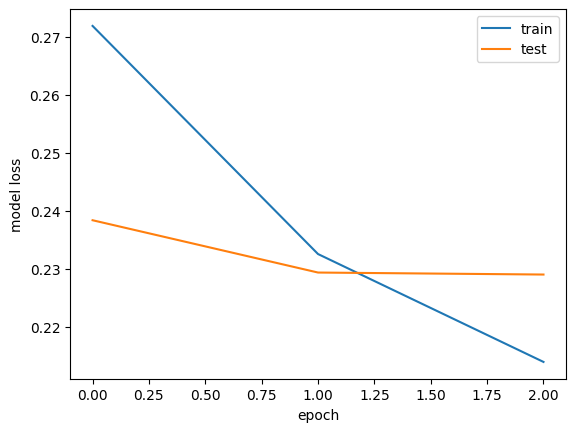

In [ ]:
# train model
history = model.fit(train_ds, validation_data=val_ds, epochs=3, verbose=1)

model.save_weights('./saved_weights.h5')

print("Validation accuracy in each epoch:", history.history['val_sparse_categorical_accuracy'])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')

plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()

In [ ]:
# store model on google drive
from google.colab import drive
drive.mount('/content/gdrive')

model.save_weights('/content/gdrive/My Drive/CIL_2023/saved_weights_roberta2.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# download model
#from google.colab import drive
#drive.mount('/content/gdrive')

trained_model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)
trained_model.load_weights('/content/gdrive/My Drive/CIL_2023/saved_weights_roberta1.h5')

In [ ]:
# predict label of a tweet
tokenizer = AutoTokenizer.from_pretrained(model_id)
tweet = ""
token = tokenizer(tweet, padding=True, truncation=True, return_tensors='tf')
logits = trained_model.predict(dict(token), verbose=1).logits
prob = tf.nn.softmax(logits, axis=1).numpy()
predictions = np.argmax(prob, axis=1)
print(predictions)